# 0. AMEX Default Prediction

Key points:

1. The data is anonymized and has been artificially noised. Start with the [parquet data by Raddar](https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format/data). 
2. The classes are imbalanced. A StratifiedKFold for cross-validation is recommended. Also, since the last statement date is the same for all customers, we cannot use TimeSeriesSplit.
3. Some missing values are systematic, and related to the statement date or the target. We can learn more in depth about it from [Raddar's notebook0(https://www.kaggle.com/code/raddar/understanding-na-values-in-amex-competition). 
4. D_39 is actually an imperative feature, days_overdue, which is essentially equivalent to the target. Delete it if you don't wanna leak the target. Details are [here](https://www.kaggle.com/code/raddar/deanonymized-days-overdue-feat-amex).
5. There are a few other redundant features according to [this](https://www.kaggle.com/competitions/amex-default-prediction/discussion/338569) and [that](https://www.kaggle.com/code/raddar/redundant-features-amex/notebook).
6. The data has a temporal structure - each customer has N months of history observed (N = 1,...,13). We choose to use the N=13 customers ONLY for simplicity.
7. Given the innate temporal structure of the data, we should consider doing feature engineering of aggregating over each customer like the following:
    - rolling averages, std, min, max for the numeric features
    - rolling counts and nuniques for the categorical features
    - First occurrence
    - Last occurrence
    - Last_diff_First: the change since we first see the customer to the last time we see the customer
    - Last/First: the fractional difference from the first to the last occurrence


# 1. Module Management and Data Import

In [1]:
# data manipulation
import os
import pandas as pd
import numpy as np
import scipy as sp
# syntax encoding
import pickle, gc
pd.options.mode.copy_on_write = True # computation
import joblib  # a tool to provide lightweight pipelining in Python. 1. easy simple parallel computing, 2. transparent disk-caching of functions and lazy re-evaluation
from tqdm import tqdm   # a fast, extensible progress bar for loops and CLI
import copy   # shallow and deep copy operations
from sklearn.base import clone

In [2]:
# modeling
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import pipeline
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_extraction import FeatureHasher
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, confusion_matrix, classification_report

In [3]:
# visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
import july

In [4]:
# Aesthetics
import gc
import warnings
sns.set_style("ticks")
sns.color_palette("husl", 8)
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['font.size'] = 10
pd.options.display.max_columns = 25
pd.options.display.max_rows = 30
pd.options.display.float_format = '{:.2f}'.format
!python --version

Python 3.9.19


## 1.2 The data import
The dataset of this competition has a considerable size. If you read the original csv files, the data barely fits into memory. Thus, we choose to work with a dataset that has reduced data precision.

Meanwhile, as it is discussed in [here by @RADDAR](https://www.kaggle.com/competitions/amex-default-prediction/discussion/328514), all float type columns have a uniform noise of Unif[0, 0.01] added to them as the artificial noise by AMEX as a safety measure to further de-anonymize them. The details are like this. The original 190 features have 1 'customer_ID', 1 'S_2' in the datetime type, 95 in the np.int8/np.int16 types, 93 in the np.float32 types. Most float columns with [0, 0.01] and [1, 1.01] have these values rounded up at 0 and 1 respectively. This was done to ensure no data loss, as not all features could be rounded up safe. As a result, the data gets shrinked in size after the noise removel as some previous float data become integers in {0, 1}.  

Based on the above two points, we decide to use the data from [@RADDAR](https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format/data). In this Parquet file, the floating point precision has been reduced from 64 bit to 32 bit, then a removal of the artificially added noise further converted some float columns to integers. 

- There are 5.5 million rows for train and 11 million rows of test data. The 'customer_ID' has no duplicates. Both of them have 190 features. The train data takes **2.72** GBytes of RAM. The test data is **twice the size** of the train data.
- The train statement dates range from 2017-03-01 to 2018-03-31.
- The test statement dates range from 2018-04-01 to 2019-10-31.
- The y_train or the target label for all customers is null free.

**Insight**:

    - Given the sheer size of datasets, memory efficiency and copy parsimony is imperative. 
    - Although the entire train data needs to be feed to the ML algorithms, we can make the predictions in batch, meaning batch processing on the test.
    - We don't have to load the test until the models have been trained and tuned. 
    - The customer_ID is in hex coding. Remove the first 16 byts and convert the rest to decimal integers.
    - (To do) Using Cudf to speed up pandas

In [5]:
# FILL NAN VALUE
NAN_VALUE = -127 # will fit in int8

y_train = pd.read_csv('data/train_labels.csv')
# Reduce the DTYPE of customer_ID
y_train['customer_ID'] = y_train['customer_ID'].str[-16:].apply(lambda x: int(x, 16)).astype(np.int64).astype('category')

X_train = pd.read_parquet('data/train.parquet')
# Reduce the DTYPE of customer_ID AND S_2 convert to date 
X_train['customer_ID'] = X_train['customer_ID'].str[-16:].apply(lambda x: int(x, 16)).astype(np.int64).astype('category')
X_train['S_2'] = pd.to_datetime(X_train['S_2']).dt.date
# Fill NaN values
X_train.fillna(NAN_VALUE, inplace=True)

with pd.option_context("display.min_rows", 4):
    display(X_train)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,-4532153018459703766,2017-03-09,0.94,0,0.01,1.01,0.01,0.12,0.00,0.00,-127.00,-127.00,...,-127.00,-1,-1,-1,-1,0,0,0.00,-127.00,0,0.00,0
1,-4532153018459703766,2017-04-07,0.94,0,0.00,1.00,0.01,0.13,0.00,0.00,-127.00,-127.00,...,-127.00,-1,-1,-1,-1,0,0,0.00,-127.00,0,0.01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531449,-8425848485496994175,2018-02-06,0.97,15,0.01,1.00,0.01,0.10,0.00,0.01,-127.00,0.01,...,-127.00,-1,-1,-1,-1,0,0,0.00,-127.00,0,0.00,0
5531450,-8425848485496994175,2018-03-14,0.98,0,0.00,0.99,0.00,0.12,0.00,0.01,-127.00,0.01,...,-127.00,-1,-1,-1,-1,0,0,0.00,-127.00,0,0.00,0


In [6]:
X_test = pd.read_parquet('data/test.parquet')
# REDUCE DTYPE FOR CUSTOMER AND DATE
X_test['customer_ID'] = X_test['customer_ID'].str[-16:].apply(lambda x: int(x, 16)).astype(np.int64).astype('category')
X_test['S_2'] = pd.to_datetime(X_test['S_2']).dt.date
# Fill NaN values
X_test.fillna(NAN_VALUE, inplace=True)

with pd.option_context("display.min_rows", 4):
    display(X_test)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,8717704911770597815,2019-02-19,0.63,0,0.01,0.81,0.00,0.17,0.00,0.00,0.11,-127.00,...,-127.00,-1,-1,-1,-1,-1,0,-127.00,-127.00,-1,0.01,-1
1,8717704911770597815,2019-03-25,0.59,0,0.01,0.81,0.00,0.24,0.00,0.01,0.12,-127.00,...,-127.00,-1,-1,-1,-1,0,0,0.00,-127.00,0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11363760,-1477111782539041971,2019-03-19,0.46,0,0.01,0.82,0.00,-127.00,0.00,0.01,0.11,-127.00,...,-127.00,-1,-1,-1,-1,0,0,0.00,-127.00,0,0.01,0
11363761,-1477111782539041971,2019-04-18,0.45,0,0.00,0.81,0.00,-127.00,0.00,0.00,0.11,-127.00,...,-127.00,-1,-1,-1,-1,0,0,0.00,-127.00,0,0.01,0


In [7]:
print(f'Train data memory usage: {X_train.memory_usage().sum() / 1e9} GBytes')
print(f'Test data memory usage:  {X_test.memory_usage().sum() / 1e9} GBytes')

Train data memory usage: 2.719927848 GBytes
Test data memory usage:  5.59809333 GBytes


In [8]:
print(f'The train statement dates range from {X_train.S_2.min()} to {X_train.S_2.max()}.')
print(f'The test statement dates range from {X_test.S_2.min()} to {X_test.S_2.max()}')

The train statement dates range from 2017-03-01 to 2018-03-31.
The test statement dates range from 2018-04-01 to 2019-10-31


# 2. EDA

## 2.1 The target label

In the train, we have 458,913 unique customer_IDs, among which 340,000 (74.1 %) have a label of 0 (never defaulted) and 119,000 (25.9 %) have a label of 1 (defaulted).
In addition, we know that the good customers have been sub-sampled by a factor of 20; this means that in reality there are 6.8 million good customers. Hence, in the original population, 98.3% of the customers are 0; 1.7% are 1.
Furthermore, we verify that the proportion of the target label is roughly consistent across each day in the time period of the train.
Finally, **the label is for the last statement for each customer ONLY, not cumulative. It actually signals whether the customer pay due amount in 120 days after his/her latest statement.**

**Insight**:

    - The classes are imbalanced. A StratifiedKFold for cross-validation is recommended.
    - Because the classes are imbalanced, accuracy would be a bad metric to evaluate a classifier. The competition metric is a mix of area under the roc curve (auc) and recall.

In [9]:
label_stats = pd.DataFrame({'Count': y_train.target.value_counts(),
              '%': y_train.target.value_counts() / len(y_train)})
label_stats['Count in population'] =  label_stats['Count'] * np.array([20, 1])
label_stats['% in population'] = label_stats['Count in population'] / label_stats['Count in population'].sum()
label_stats

,Count,%,Count in population,% in population
target,,,,
0,340085,0.74,6801700,0.98
1,118828,0.26,118828,0.02


## 2.2  The statement counts per customer

We'd like to know how many rows (credit card statements) each customer has. We see that 80% of the customers have 13 statements; the other 20% of the customers have between 1 and 12 statements.

**Insight**:
    - The data has a temporal structure - each customer has N months of history observed (N = 1,...,13). 
    - Our model needs to able to deal with a variable observed history record lengths (N) per customer. A good way to pull it through is via adding new customer-level historical aggregated features in the later parts. 
    - Optionally, we could choose to use the N=13 customers ONLY for simplicity.  

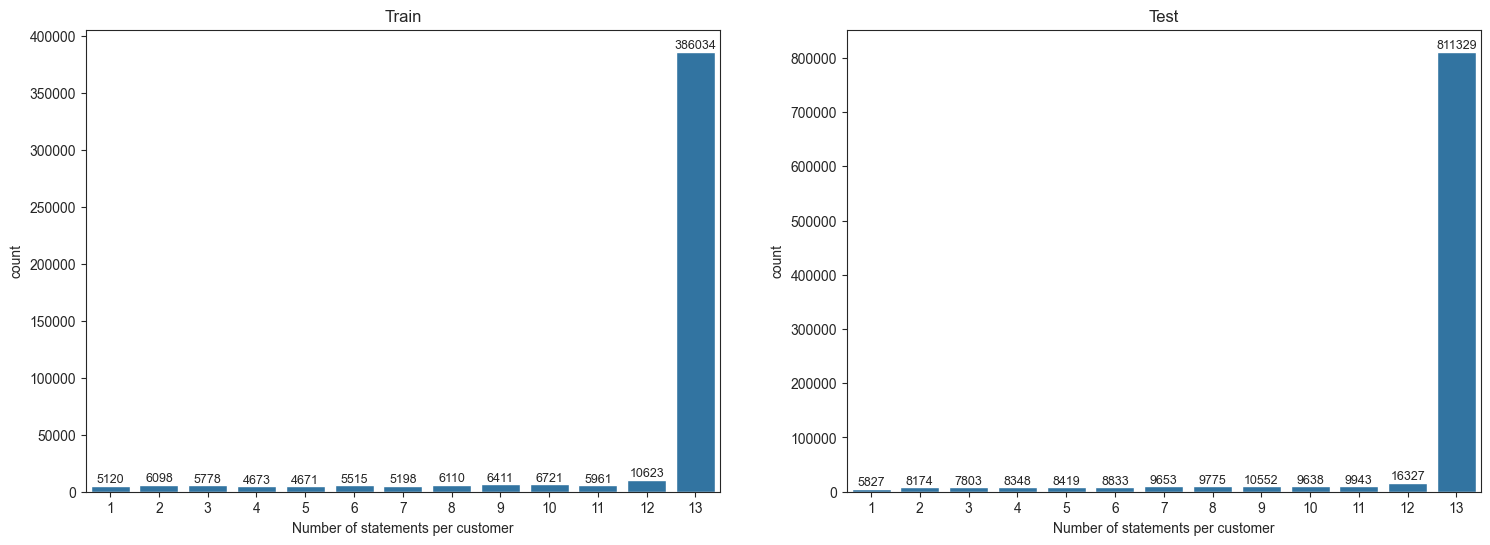

In [10]:
# plot the number of statements per customer as barplots in the train and test data
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(X_train.customer_ID.value_counts().value_counts().sort_index(ascending=False), ax=ax[0])
ax[0].bar_label(ax[0].containers[0], fmt='%.0f', label_type='edge', fontsize=9)
ax[0].set_xlabel('Number of statements per customer')
ax[0].set_title('Train')
sns.barplot(X_test.customer_ID.value_counts().value_counts().sort_index(ascending=False), ax=ax[1])
ax[1].bar_label(ax[1].containers[0], fmt='%.0f', label_type='edge', fontsize=9)
ax[1].set_xlabel('Number of statements per customer')
ax[1].set_title('Test')
plt.show()

Let's find out when these customers got their last statement. The histogram of the last statement dates shows that every train customer got his last statement in March of 2018. The first four Saturdays (March 3, 10, 17, 24) have more statements than an average day.

The test customers are split in two: half of them got their last statement in April of 2019 and half in October of 2019. As was discussed here, the April 2019 data is used for the public leaderboard and the October 2019 data is used for the private leaderboard.

Although the data are a kind of time series, we cannot cross-validate with a TimeSeriesSplit because all training happens in the same month.

For most customers, the first and last statement is about a year apart. Together with the fact that we typically have 13 statements per customer, this indicates that the customers get one credit card statement every month.

C:\Users\Han\AppData\Local\Temp\ipykernel_8828\4007365386.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_last_date = X_train.S_2.groupby(X_train.customer_ID).max()


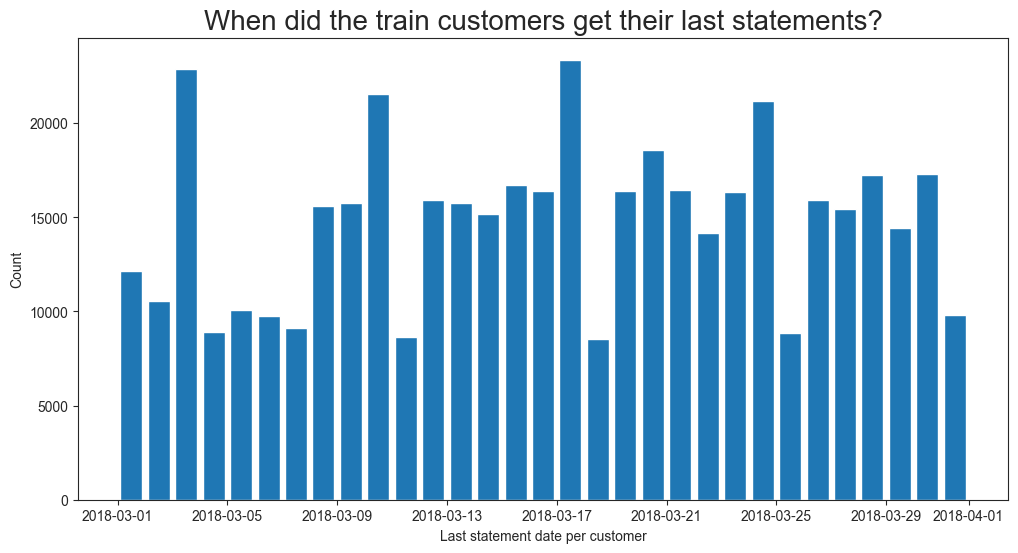

In [11]:
train_last_date = X_train.S_2.groupby(X_train.customer_ID).max()
plt.hist(train_last_date, bins=pd.date_range("2018-03-01", "2018-04-01", freq="d"),
         rwidth=0.8)
plt.title('When did the train customers get their last statements?', fontsize=20)
plt.xlabel('Last statement date per customer')
plt.ylabel('Count')
plt.show()
del train_last_date

C:\Users\Han\AppData\Local\Temp\ipykernel_8828\767986266.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test_last_date = X_test.S_2.groupby(X_test.customer_ID).max()


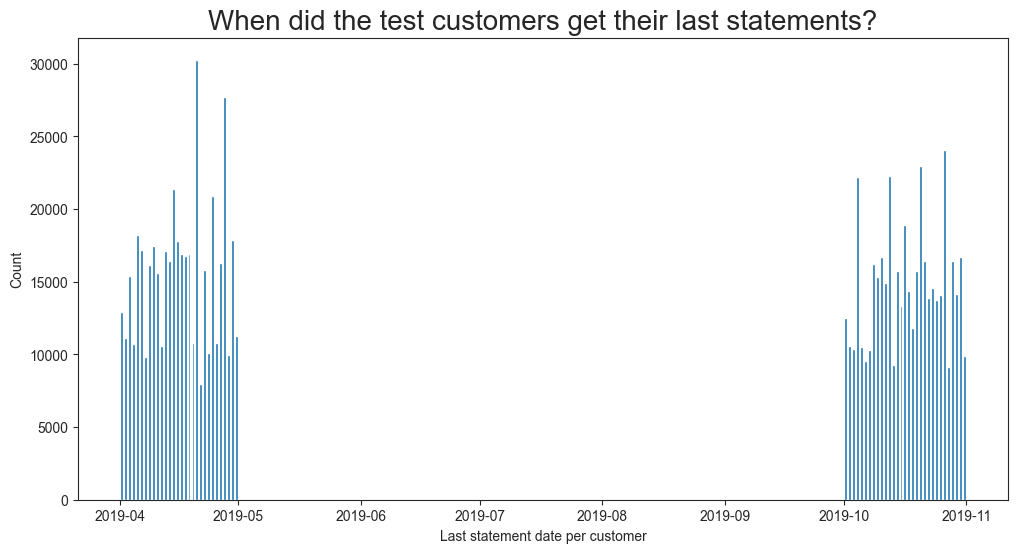

In [12]:
test_last_date = X_test.S_2.groupby(X_test.customer_ID).max()
plt.hist(test_last_date, bins=pd.date_range("2019-04-01", "2019-11-01", freq="d"),
         rwidth=0.74)
plt.title('When did the test customers get their last statements?', fontsize=20)
plt.xlabel('Last statement date per customer')
plt.ylabel('Count')
plt.show()
del test_last_date

If we color every statement (i.e. row of train or test) according to the dataset it belongs (training, public lb, and private lb), we see that every dataset covers thirteen months. Train and test don't overlap, but public and private lb periods overlap.

In [24]:
temp = pd.concat([X_train[['customer_ID', 'S_2']], X_test[['customer_ID', 'S_2']]], axis=0)
temp.set_index('customer_ID', inplace=True)


In [37]:
# for each customer_ID, get the last statement date's month value using groupby
temp = temp.groupby(temp.index).S_2.max().dt.month


AttributeError: Can only use .dt accessor with datetimelike values

In [36]:
temp['last_month'] = temp.groupby('customer_ID').S_2.max().month

AttributeError: 'Series' object has no attribute 'month'

In [35]:
temp.head()

,S_2
customer_ID,
-4532153018459703766,2017-03-09
-4532153018459703766,2017-04-07
-4532153018459703766,2017-05-28
-4532153018459703766,2017-06-13
-4532153018459703766,2017-07-16


In [25]:
temp['last_month'] = temp.groupby('customer_ID').S_2.max().month
last_month = temp['last_month'].values


AttributeError: 'Series' object has no attribute 'month'

In [ ]:

plt.figure(figsize=(16, 4))
plt.hist([temp.S_2[temp.last_month == 3],   # ending 03/18 -> training
          temp.S_2[temp.last_month == 4],   # ending 04/19 -> public lb
          temp.S_2[temp.last_month == 10]], # ending 10/19 -> private lb
         bins=pd.date_range("2017-03-01", "2019-11-01", freq="MS"),
         label=['Training', 'Public leaderboard', 'Private leaderboard'],
         stacked=True)
plt.xticks(pd.date_range("2017-03-01", "2019-11-01", freq="QS"))
plt.xlabel('Statement date')
plt.ylabel('Count')
plt.title('The three datasets over time', fontsize=20)
plt.legend()
plt.show()

In [ ]:
## 2.3 'S_2' datetime stamp related distribution
 

In [17]:
target=pd.DataFrame(data={'Default':X_train.groupby('S_2')['target'].mean()*100})
target['Paid']=np.abs(X_train.groupby('S_2')['target'].mean()-1)*100
pal, color=['#016CC9','#DEB078'], ['#8DBAE2','#EDD3B3']
temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=1000))
rgb=['rgba'+str(matplotlib.colors.to_rgba(i,0.7)) for i in pal]
fig=go.Figure()
fig.add_trace(go.Bar(x=target.index, y=target.Paid, name='Paid',
                     text=target.Paid, texttemplate='%{text:.0f}%', 
                     textposition='inside',insidetextanchor="middle",
                     marker=dict(color=color[0],line=dict(color=pal[0],width=1.5)),
                     hovertemplate = "<b>%{x}</b><br>Paid accounts: %{y:.2f}%"))
fig.add_trace(go.Bar(x=target.index, y=target.Default, name='Default',
                     text=target.Default, texttemplate='%{text:.0f}%', 
                     textposition='inside',insidetextanchor="middle",
                     marker=dict(color=color[1],line=dict(color=pal[1],width=1.5)),
                     hovertemplate = "<b>%{x}</b><br>Default accounts: %{y:.2f}%"))
fig.update_layout(template=temp,title='Distribution of Default by Date', 
                  barmode='relative', yaxis_ticksuffix='%', width=1400,
                  legend=dict(orientation="h", traceorder="reversed", yanchor="bottom",y=1.1,xanchor="left", x=0))
fig.show()

KeyError: 'Column not found: target'

## 2.3 Missing values

- 121 out of 189 features have missing values. The percentage of missing values ranges from 0.1% to 99.9%.
- 25 features' missing rates exceed 70%. Most likely beyond salvage, unless their missing rate drop considerably after the historical aggregates. 
- 6 features have missing rates between 30% and 70%. We may consider imputing them.
- 90 features have missing rates below 30%. We are inclined to imputing them respectively. 
- check out this for systemic NAs , https://www.kaggle.com/code/raddar/understanding-na-values-in-amex-competition

**Insight:**
    - Is the missing caused by feature truncated? Most features are 16-bit floats. The original data (in the csv file) has higher precision. By rounding it to 16-bit precision, some information is lost, meaning only the first 3 digits after the decimal point are preserved.
    - The missing values are not missing at random. The missing values are related to the statement date. For example, the feature B_29 has missing values until May of 2019. Starting in June of 2019, we have B_29 data for almost every customer. This is a feature that we should be careful with.
    - The missing values are not missing at random. The missing values are related to the target. For example, the feature D_87 has missing values only for customers with target 0. This is a feature that we should be careful with. 
    - Need to choose the missing imputation methods, like KNN, RF, constant/statistic filler carefully.

In [32]:
# show the percentage of missing values in the train data
missing = X_train.isna().mean().sort_values(ascending=False).rename('missing %')
missing = missing[missing > 0]
missing

Series([], Name: missing %, dtype: float64)

In [110]:
fea_100_70_missing = missing[missing > 0.7].index
fea_100_70_missing

Index(['D_87', 'D_88', 'D_108', 'D_111', 'D_110', 'B_39', 'D_73', 'B_42',
       'D_135', 'D_138', 'D_134', 'D_136', 'D_137', 'R_9', 'B_29', 'D_106',
       'D_132', 'D_49', 'R_26', 'D_76', 'D_66', 'D_42', 'D_142', 'D_53',
       'D_82'],
      dtype='object')

In [111]:
fea_70_30_missing = missing[(missing > 0.3) & (missing<0.7)].index
fea_70_30_missing

Index(['D_50', 'B_17', 'D_105', 'D_56', 'S_9', 'D_77'], dtype='object')

In [112]:
fea_30_0_missing = missing[missing < 0.3].index
fea_30_0_missing

Index(['D_43', 'S_27', 'D_46', 'S_7', 'S_3', 'D_62', 'D_48', 'D_61', 'P_3',
       'D_44', 'D_78', 'D_68', 'D_83', 'D_69', 'D_55', 'D_123', 'D_116',
       'D_121', 'D_114', 'D_119', 'D_122', 'D_115', 'D_120', 'D_124', 'D_125',
       'D_113', 'D_117', 'D_118', 'D_91', 'R_27', 'D_126', 'D_59', 'D_107',
       'D_104', 'D_103', 'D_145', 'D_129', 'D_130', 'D_143', 'D_141', 'D_128',
       'D_131', 'D_139', 'D_70', 'D_79', 'B_13', 'P_2', 'D_133', 'D_144',
       'D_102', 'D_140', 'D_84', 'D_52', 'D_89', 'D_81', 'D_72', 'B_8', 'D_74',
       'D_80', 'S_22', 'S_24', 'S_25', 'B_15', 'B_25', 'D_112', 'D_45', 'B_27',
       'B_20', 'B_33', 'B_19', 'B_16', 'B_2', 'D_41', 'B_3', 'D_54', 'B_30',
       'B_26', 'B_38', 'B_22', 'D_109', 'B_41', 'S_26', 'S_23', 'B_6', 'R_20',
       'R_12', 'B_37', 'B_40', 'R_7', 'R_14'],
      dtype='object')

Now we'll look at the distribution of missing values over time. B_29 is most interesting. Given the each of the three datasets has almost half a million customers, we see that until May of 2019 fewer than a tenth of the customers have a value for B_29. The other nine tenths are missing. Starting in June of 2019, we have B_29 data for almost every customer.

**Insight:** 
    - The test data come from a different phase in the economic cycle than the training data. Our models have no way of learning the effect of the economic cycle.
    - The distribution of the missing B_29 differs between train and test datasets. Whereas in the training and public leaderboard data >90 % are missing, during the last five months of private leaderboard, we have B_29 data for almost every customer. If we use this feature, we should be prepared for surprises in the private leaderboard. Is it better to drop the feature?

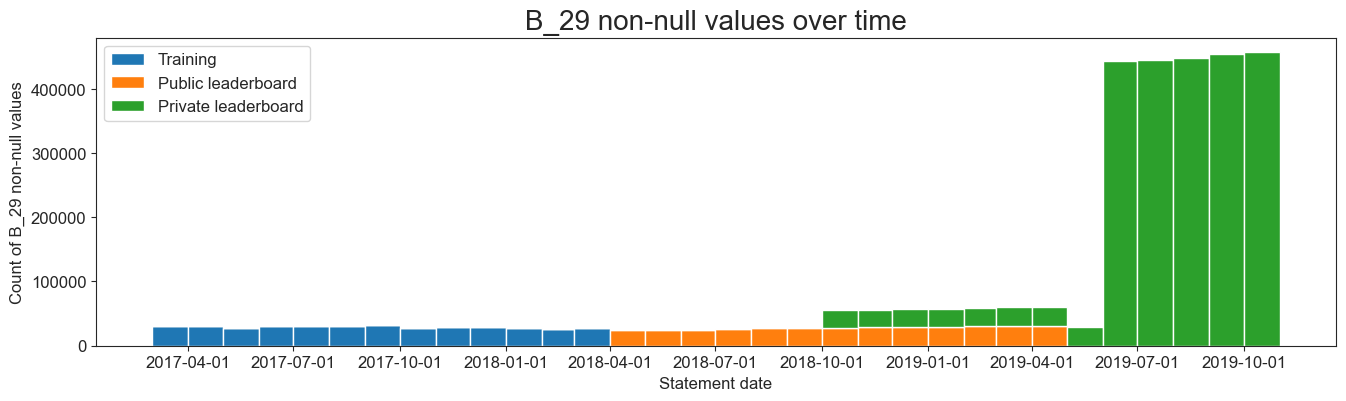

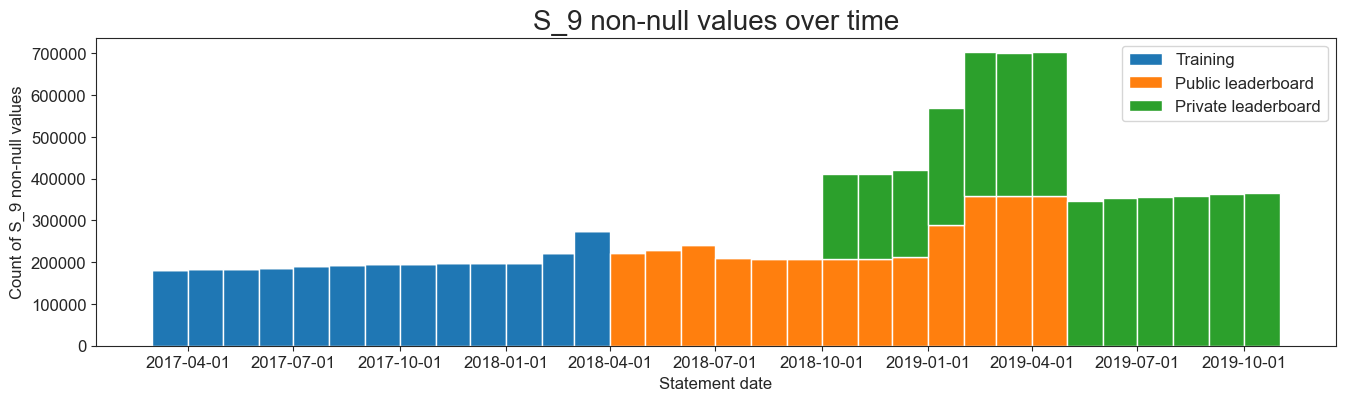

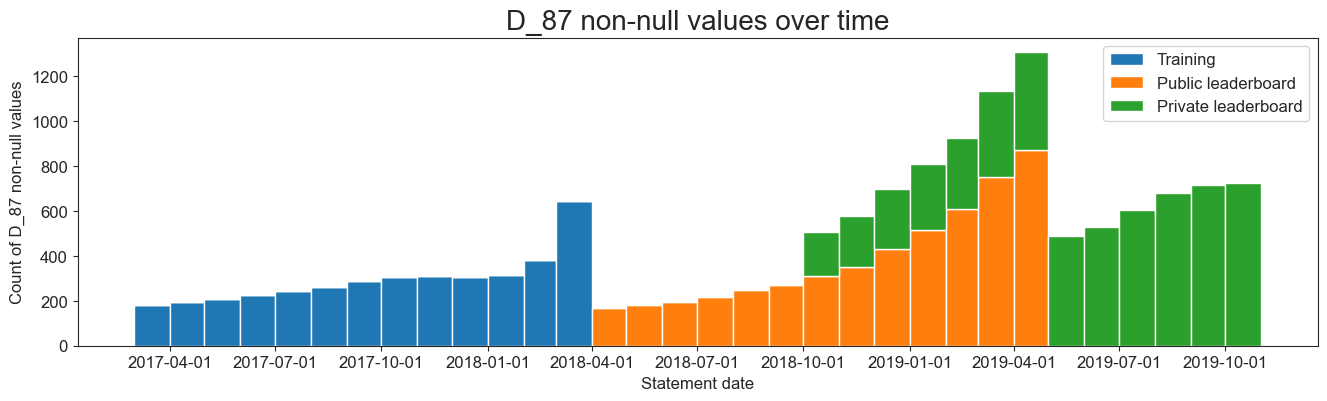

In [103]:
for f in [ 'B_29', 'S_9','D_87']:#, 'D_88', 'R_26', 'R_27', 'D_108', 'D_110', 'D_111', 'B_39', 'B_42']:
    temp = pd.concat([X_train[[f, 'S_2']], X_test[[f, 'S_2']]], axis=0)
    temp['last_month'] = last_month
    temp['has_f'] = ~temp[f].isna() 

    plt.figure(figsize=(16, 4))
    plt.hist([temp.S_2[temp.has_f & (temp.last_month == 3)],   # ending 03/18 -> training
              temp.S_2[temp.has_f & (temp.last_month == 4)],   # ending 04/19 -> public lb
              temp.S_2[temp.has_f & (temp.last_month == 10)]], # ending 10/19 -> private lb
             bins=pd.date_range("2017-03-01", "2019-11-01", freq="MS"),
             label=['Training', 'Public leaderboard', 'Private leaderboard'],
             stacked=True)
    plt.xticks(pd.date_range("2017-03-01", "2019-11-01", freq="QS"))
    plt.xlabel('Statement date')
    plt.ylabel(f'Count of {f} non-null values')
    plt.title(f'{f} non-null values over time', fontsize=20)
    plt.legend()
    plt.show()
del temp

## 2.4 The categorical features

According to the data description, there are 13 categorical features. We plot histograms for target=0 and target=1. For the ten features which have missing values, the missing values are represented by the rightmost bar of the histogram.

**Insight:**

    - All categorical features has below 10 as their cardinarlities. So, we can use one-hot encoding safely.
    - D_87 is a feature that has missing values only for customers with target 0. This is a evidance that some missing values should just be imputed as 0.   

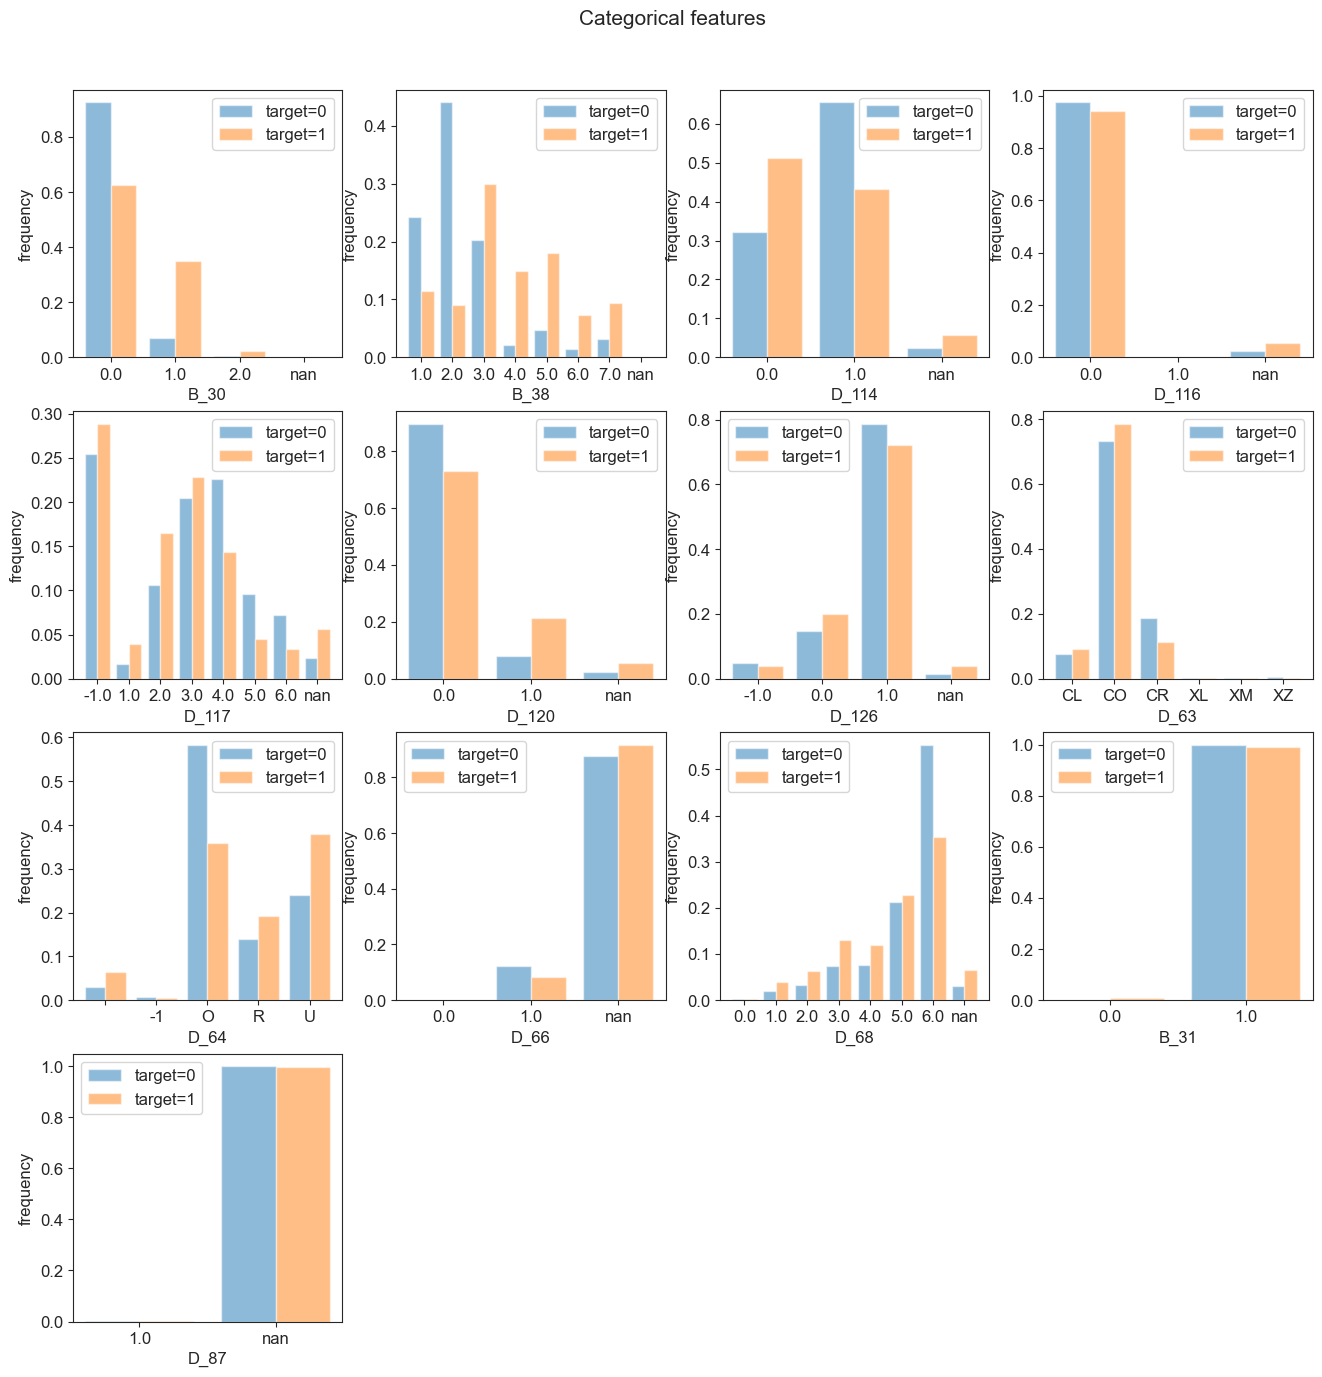

In [115]:
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68', 'B_31', 'D_87']
plt.figure(figsize=(16, 16))
for i, f in enumerate(cat_features):
    plt.subplot(4, 4, i+1)
    temp_0 = pd.DataFrame(X_train[f][X_train.target == 0].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp_0.index.name = 'value'
    temp_0.reset_index(inplace=True)
    temp_1 = pd.DataFrame(X_train[f][X_train.target == 1].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp_1.index.name = 'value'
    temp_1.reset_index(inplace=True)
    width = 0.4  # width of the bars
    plt.bar(temp_0.index - width/2, temp_0['count'], width=width, alpha=0.5, label='target=0')
    plt.bar(temp_1.index + width/2, temp_1['count'], width=width, alpha=0.5, label='target=1')
    plt.xlabel(f)
    plt.ylabel('frequency')
    plt.legend()
    plt.xticks(temp_0.index, temp_0.value)
plt.suptitle('Categorical features', fontsize=15, y=0.93)
plt.show()
del temp_0, temp_1

## 2.5 The numerical features

As it discussed [here](https://www.kaggle.com/code/ambrosm/amex-eda-which-makes-sense/notebook#The-artificial-noise-in-the-data) and [here](https://www.kaggle.com/competitions/amex-default-prediction/discussion/328514), the data has been artificially noised --  **all float type columns have random uniform noise of [0,0.01] added to each column. Having this information it is clear that it is very easy to spot integer type columns in the raw data.**

They have deducted that the anonymize function they use is something like this:

```python
def anonymize(data):
    data -= data.min() # minus the minimum value
    data /= data.max() # devide by the maximum value
    rng = np.random.default_rng()
    data += rng.uniform(0, 0.01, len(data)) # add artificial uniform noise
    return data
```
As a response, the did the following on the original 188 float/categorical type features. They were transformed into
- 95 np.int8/np.int16 types
- 93 np.float16 types
They found out that most float columns with [0, 0.01] and [1, 1.01] have these values rounded up at 0 and 1 respectively. This was done to ensure no data loss, as not all features could be rounded up safely.
saved in parquet format (only 1.7GB training data!)

And use the [parquet data](https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format) to build the model.